# Introduction to Convolutional Neural Networks and Computer Vision
Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognizing the car in front.
The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However we've modified it to only use two classes (pizza 🍕 & steak 🥩) using the image data modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb




In [13]:
import zipfile
# Unzip the download file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

## Inspect the data (Become one with it)

In [1]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak\test'.
There are 0 directories and 250 images in 'pizza_steak\test\pizza'.
There are 0 directories and 250 images in 'pizza_steak\test\steak'.
There are 2 directories and 0 images in 'pizza_steak\train'.
There are 0 directories and 750 images in 'pizza_steak\train\pizza'.
There are 0 directories and 750 images in 'pizza_steak\train\steak'.


In [2]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

In [3]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [4]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image(target_dir, target_class):
    # Setup target directory (we'llview images from here)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")  # Show the shape of the image

    return img

Image shape: (384, 512, 3)


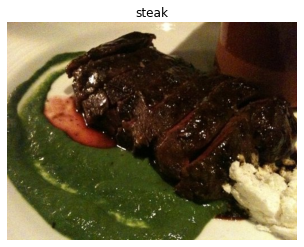

In [5]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

In [6]:
# The images we've imported and plotted are actually giant arrays/tensors of different pixel values
import tensorflow as tf
tf.constant(img)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[161, 135, 112],
        [163, 137, 114],
        [163, 137, 114],
        ...,
        [ 37,  18,  11],
        [ 40,  19,  14],
        [ 40,  19,  14]],

       [[164, 138, 113],
        [163, 137, 112],
        [166, 140, 115],
        ...,
        [ 42,  23,  16],
        [ 43,  22,  17],
        [ 41,  20,  15]],

       [[166, 143, 112],
        [161, 138, 107],
        [165, 140, 109],
        ...,
        [ 42,  22,  15],
        [ 44,  21,  15],
        [ 41,  18,  12]],

       ...,

       [[231, 211, 178],
        [229, 209, 174],
        [232, 212, 177],
        ...,
        [207, 183, 111],
        [208, 183, 117],
        [204, 179, 113]],

       [[229, 209, 174],
        [227, 207, 172],
        [230, 210, 175],
        ...,
        [211, 187, 113],
        [204, 179, 112],
        [195, 170, 103]],

       [[228, 208, 173],
        [225, 205, 170],
        [226, 206, 169],
        ...,
        [199, 175, 10

In [7]:
# View the image shape
img.shape       # return (width,height, color channels)

(384, 512, 3)

In [8]:
# Get all the pixel values between 0 & 1
img/255.

array([[[0.63137255, 0.52941176, 0.43921569],
        [0.63921569, 0.5372549 , 0.44705882],
        [0.63921569, 0.5372549 , 0.44705882],
        ...,
        [0.14509804, 0.07058824, 0.04313725],
        [0.15686275, 0.0745098 , 0.05490196],
        [0.15686275, 0.0745098 , 0.05490196]],

       [[0.64313725, 0.54117647, 0.44313725],
        [0.63921569, 0.5372549 , 0.43921569],
        [0.65098039, 0.54901961, 0.45098039],
        ...,
        [0.16470588, 0.09019608, 0.0627451 ],
        [0.16862745, 0.08627451, 0.06666667],
        [0.16078431, 0.07843137, 0.05882353]],

       [[0.65098039, 0.56078431, 0.43921569],
        [0.63137255, 0.54117647, 0.41960784],
        [0.64705882, 0.54901961, 0.42745098],
        ...,
        [0.16470588, 0.08627451, 0.05882353],
        [0.17254902, 0.08235294, 0.05882353],
        [0.16078431, 0.07058824, 0.04705882]],

       ...,

       [[0.90588235, 0.82745098, 0.69803922],
        [0.89803922, 0.81960784, 0.68235294],
        [0.90980392, 0

## An end-to-end example
Let's build a convolutional neural network to find patterns in our images, more specifically we a need way to:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2,
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
